In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp

import optax
import flax.linen as nn
from flax.linen import DenseGeneral

from st_modules import MAB, SAB, ISAB, PMA

In [2]:
def gen_data(batch_size, max_length=10, test=False):
    length = np.random.randint(1, max_length + 1)
    x = np.random.randint(1, 100, (batch_size, length))
    y = np.max(x, axis=1)
    x, y = np.expand_dims(x, axis=2), np.expand_dims(y, axis=1)
    return x, y

def make_train(st, optimizer):
    @jax.jit
    def train_step(x,y,params_in, state_in):
        def loss(params):
            pred = st.apply(params,x)
            return jnp.mean(jnp.abs(pred-y))
        val, grad = jax.value_and_grad(loss)(params_in)
        updates, state_out = optimizer.update(grad, state_in, params_in)
        params_out = optax.apply_updates(params_in, updates)

        return val, params_out, state_out
    return train_step

0/20
1/20
2/20
3/20
4/20
5/20
6/20
7/20
8/20
9/20
10/20
11/20
12/20
13/20
14/20
15/20
16/20
17/20
18/20
19/20
-0.33252183


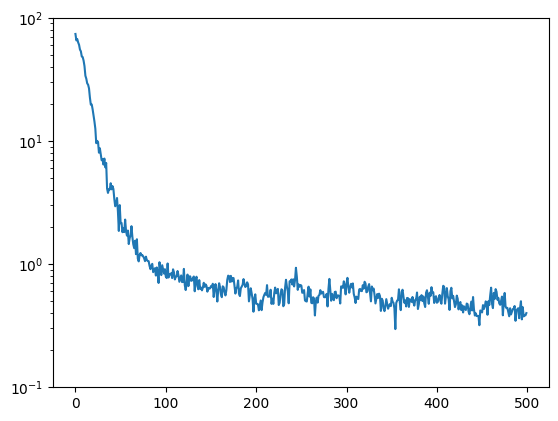

In [3]:
class SmallSetTransfromer(nn.Module):
    @nn.compact
    def __call__(self,x):
        x = SAB(N_head=4, N_dim=64)(x)
        x = SAB(N_head=4, N_dim=64)(x)
        x = PMA(N_head=4, N_dim=64, N_seed=1)(x)
        return DenseGeneral(1,axis=(-2,-1),
                            kernel_init =  nn.initializers.variance_scaling(scale = 1/3,
                                                                            mode = "fan_in",
                                                                            distribution = "uniform"))(x)

st = SmallSetTransfromer()
optimizer_def = optax.adam(learning_rate= 10**-4)
train_step = make_train(st,optimizer_def)

N_test = 20
losses = []

for SEED in range(N_test):
    rng = jax.random.PRNGKey(SEED)
    np.random.seed(SEED)
    
    rng, key = jax.random.split(rng)
    x,y = gen_data(batch_size=2**10)
    params_st = st.init(key,x)
    opt_state = optimizer_def.init(params_st)

    for i in range(500):
        x,y = gen_data(batch_size=2**10, max_length=10)
        val, params_st, opt_state = train_step(x,y,params_st, opt_state)
        losses.append(val)
    print(f"{SEED}/{N_test}")
        
_losses = np.array(losses).reshape(N_test,-1)
plt.plot(np.mean(_losses,axis=0))
plt.ylim([10**-1,10**2])
plt.yscale("log")
print(np.mean(np.log10(np.mean(_losses,axis=0))[-100:]))

0/20
1/20
2/20
3/20
4/20
5/20
6/20
7/20
8/20
9/20
10/20
11/20
12/20
13/20
14/20
15/20
16/20
17/20
18/20
19/20
-0.10666499


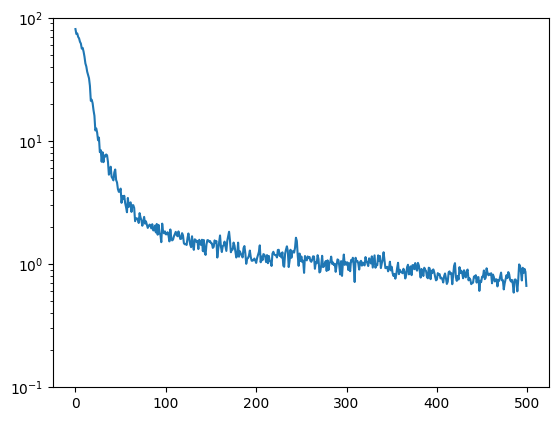

In [4]:
class SmallSetTransfromer(nn.Module):
    @nn.compact
    def __call__(self,x):
        x = ISAB(N_head=4, N_dim=64, N_induced = 5)(x)
        x = ISAB(N_head=4, N_dim=64, N_induced = 5)(x)
        x = PMA(N_head=4, N_dim=64, N_seed=1)(x)
        return DenseGeneral(1,axis=(-2,-1),
                            kernel_init =  nn.initializers.variance_scaling(scale = 1/3,
                                                                            mode = "fan_in",
                                                                            distribution = "uniform"))(x)

st = SmallSetTransfromer()
optimizer_def = optax.adam(learning_rate= 10**-4)
train_step = make_train(st,optimizer_def)

N_test = 20
losses = []

for SEED in range(N_test):
    rng = jax.random.PRNGKey(SEED)
    np.random.seed(SEED)
    
    rng, key = jax.random.split(rng)
    x,y = gen_data(batch_size=2**10)
    params_st = st.init(key,x)
    opt_state = optimizer_def.init(params_st)

    for i in range(500):
        x,y = gen_data(batch_size=2**10, max_length=10)
        val, params_st, opt_state = train_step(x,y,params_st, opt_state)
        losses.append(val)
    print(f"{SEED}/{N_test}")
        
_losses = np.array(losses).reshape(N_test,-1)
plt.plot(np.mean(_losses,axis=0))
plt.ylim([10**-1,10**2])
plt.yscale("log")
print(np.mean(np.log10(np.mean(_losses,axis=0))[-100:]))